# Aprendizaje de máquina - Proyecto final (Continuación)

**Continuación del análisis del notebook**: [FIFA2026.ipynb](FIFA2026.ipynb)

Modificamos el **objetivo**, de modo que ahora se plantea predecir el resultado de los partidos por victoria vs no victoria del local (win, no win).

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, average_precision_score 
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_fscore_support, precision_recall_curve
import os

##### 1) EDA: Comprensión inicial del dataset, estadísticas descriptivas, identificación de variables, visualizaciones para entender distribuciones, correlaciones y posibles problemas como valores nulos o atípico.

Dado que ya se hizo el EDA en el notebook [FIFA2026.ipynb](FIFA2026.ipynb), vamos a limitarnos a lo mínimo indispensable para el caso de win vs no win

In [48]:
results = pd.read_csv("./archive/results.csv")
results["date"] = pd.to_datetime(results["date"])

Se procede a crear la variable target

In [49]:
results["year"] = results["date"].dt.year
results["month"] = results["date"].dt.month
results["dayofweek"] = results["date"].dt.dayofweek
results["is_weekend"] = results["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

results["goal_diff"] = abs(results["home_score"] - results["away_score"])
results["total_score"] = results["home_score"] + results["away_score"]

results["result"] = results.apply(
    lambda row: "win" if row["home_score"] > row["away_score"] else "nowin",
    axis=1)

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,dayofweek,is_weekend,goal_diff,total_score,result
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,11,5,1,0,0,nowin
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873,3,5,1,2,6,win
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,3,5,1,1,3,win
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875,3,5,1,0,4,nowin
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,3,5,1,3,3,win


Veamos la distribución del target

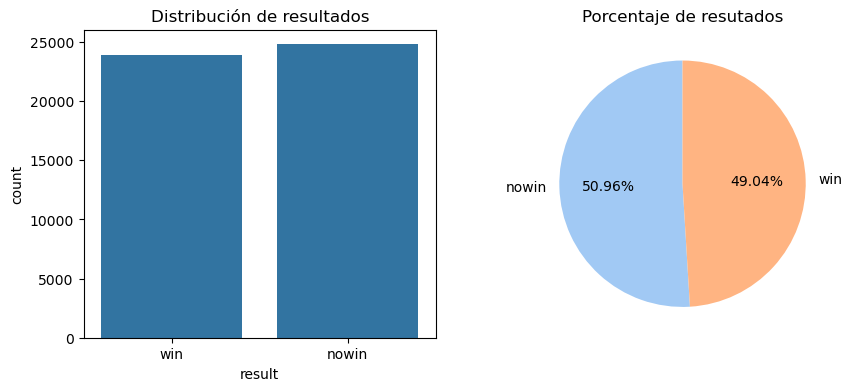

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=results, x="result", order=["win","nowin"], ax=ax[0])
ax[0].set_title("Distribución de resultados")

results_counts = results['result'].value_counts()
ax[1].pie(results_counts, labels=results_counts.index, autopct='%1.2f%%', startangle=90, colors=sns.color_palette('pastel'))
ax[1].set_title('Porcentaje de resutados')

plt.show()

📝 A partir de los graficos de los resultados, vemos una gran mejora en el balance en las clases. Se podría decir que el dataset queda balanceado en relación al target.

 ##### 2) Preprocesamiento y Preparación de Datos: Descripción de las transformaciones aplicadas a los datos para prepararlos para el modelado. Esto incluye, pero no se limita a: limpieza de datos, imputación de valores faltantes, codificación de variables categóricas, escalado de características, etc.

📝 Igual que en el anterior, vamos a basarnos en el rating elo de los dos equipos y la diferencia entre ambos.

In [51]:
from collections import deque
from math import log

# Parámetros 
R0 = 1500.0
K_base = 20.0
HOME_ADV = 80.0           # ventaja local en puntos ELO
half_life_years = 2.0     # half-life (2 o 3 años suelen andar muy bien)
half_life_days  = 365.0 * half_life_years
N_prev = 20               # ← cantidad de partidos “hacia atrás” por equipo

# Pesos por torneo (ajustables). Default = 1.1.
weights = {
    "FIFA World Cup": 1.6,
    "UEFA European Championship": 1.4,
    "Copa América": 1.4,
    "FIFA World Cup qualification": 1.3,
    "UEFA Nations League": 1.2
}
def w_tournament(t):
    return weights.get(t, 1.1)  # ← default sensato

def elo_expect(Ra, Rb, home_adv):
    return 1.0 / (1.0 + 10.0 ** ((Rb - (Ra + home_adv)) / 400.0))

def compute_elo_features(df):
    """Calcula ELO de forma cronológica."""
    ratings, last_played, recent_counts = {}, {}, {}
    snapshots = []

    df = df.sort_values("date").copy()
    for _, row in df.iterrows():
        d, ht, at = row["date"], row["home_team"], row["away_team"]
        hs, as_, tour, neut = row["home_score"], row["away_score"], row["tournament"], bool(row["neutral"])

        for team in (ht, at):
            if team not in ratings: ratings[team] = R0
            if team not in recent_counts: recent_counts[team] = deque(maxlen=N_prev)
            if team in last_played:
                delta_days = (d - last_played[team]).days
                if delta_days > 0:
                    decay = 0.5 ** (delta_days / half_life_days)
                    ratings[team] = R0 + (ratings[team] - R0) * decay

        Rh_pre, Ra_pre = ratings[ht], ratings[at]  # ratings antes del partido
        home_adv = 0 if neut else HOME_ADV
        Eh = elo_expect(Rh_pre, Ra_pre, home_adv)
        Ea = 1 - Eh

        # Resultado
        if hs > as_: Sh, Sa = 1, 0
        elif hs < as_: Sh, Sa = 0, 1
        else: Sh, Sa = 0.5, 0.5

        margin = max(1, log(1 + abs(hs - as_), 2))
        Kw_base = K_base * w_tournament(tour) * margin
        cnt_h, cnt_a = len(recent_counts[ht]), len(recent_counts[at])
        factor_h, factor_a = min(1, cnt_h / N_prev), min(1, cnt_a / N_prev)
        Kw_h, Kw_a = Kw_base * (0.5 + 0.5 * factor_h), Kw_base * (0.5 + 0.5 * factor_a)

        # Actualizamos después del partido
        ratings[ht] = Rh_pre + Kw_h * (Sh - Eh)
        ratings[at] = Ra_pre + Kw_a * (Sa - Ea)

        recent_counts[ht].append(d)
        recent_counts[at].append(d)
        last_played[ht], last_played[at] = d, d

        # Guardamos el snapshot usando los ratings previos al partido
        snapshots.append({
            "date": d,
            "home_team": ht,
            "away_team": at,
            "home_rating": Rh_pre,
            "away_rating": Ra_pre
        })

    elo_df = pd.DataFrame(snapshots)
    elo_df["rating_diff"] = elo_df["home_rating"] - elo_df["away_rating"]
    return elo_df

📝 Aplicamos los mismos criterios de filtrado del caso anterior (win / draw / loss)

Y creamos la variable target ```{1: "win", 0: "nowin"}``` y los features acorde al caso anterior. 

In [52]:
results_filtered = results[results["year"] >= 1920].reset_index(drop=True)
results_filtered = results_filtered[results_filtered["tournament"] != 'Friendly'].reset_index(drop=True)

print("Original", results.shape)
print("Filtrado", results_filtered.shape)

# Nuevas features
results_filtered["goal_diff"] = results_filtered["home_score"] - results_filtered["away_score"]

results_filtered["target"] = np.where(results_filtered["goal_diff"] > 0, 1, 0)

results_filtered["year"] = results_filtered["date"].dt.year
results_filtered["month"] = results_filtered["date"].dt.month
results_filtered["dayofweek"] = results_filtered["date"].dt.dayofweek
results_filtered["neutral"] = results_filtered["neutral"].astype(int)

# Calcular ELO
elo_df = compute_elo_features(results_filtered)
results_with_rating = results_filtered.merge(
    elo_df, on=["date", "home_team", "away_team"], how="left"
)

Original (48673, 16)
Filtrado (30209, 16)


In [53]:
print("Nulos en base al procesamiento:\n", results_filtered.isna().sum()[results_filtered.isna().sum() > 0])

Nulos en base al procesamiento:
 Series([], dtype: int64)


No aparecen valores nulos después de los cálculos.

Hacemos el split del dataset y usamos la misma codificación para las variables categoricas, y se estandarizan las variables para que todas tengan la misma escala.

In [54]:
results_filtered.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,dayofweek,is_weekend,goal_diff,total_score,result,target
30204,2025-10-14,Republic of Ireland,Armenia,1,0,FIFA World Cup qualification,Dublin,Republic of Ireland,0,2025,10,1,0,1,1,win,1
30205,2025-10-14,Estonia,Moldova,1,1,FIFA World Cup qualification,Tallinn,Estonia,0,2025,10,1,0,0,2,nowin,0
30206,2025-10-14,Italy,Israel,3,0,FIFA World Cup qualification,Udine,Italy,0,2025,10,1,0,3,3,win,1
30207,2025-10-14,Andorra,Serbia,1,3,FIFA World Cup qualification,Encamp,Andorra,0,2025,10,1,0,-2,4,nowin,0
30208,2025-10-14,Latvia,England,0,5,FIFA World Cup qualification,Riga,Latvia,0,2025,10,1,0,-5,5,nowin,0


In [55]:

# Features
feat_cat = ["home_team", "away_team", "tournament"]
feat_num = ["neutral", "year", "month", "dayofweek", "rating_diff"]

X = results_with_rating[feat_cat + feat_num]
y = results_with_rating["target"]

# Ordenamos por el rating_diff a favor del local para corroborar la consistencia de la diferencia entre equipos
# Claramente favorable al local
X.sort_values("rating_diff", ascending=False).head(10)

,home_team,away_team,tournament,neutral,year,month,dayofweek,rating_diff
25896,Belgium,San Marino,UEFA Euro qualification,0,2019,10,3,432.893210
28645,France,Gibraltar,UEFA Euro qualification,0,2023,11,5,377.644401
3854,Myanmar,Singapore,Merdeka Tournament,1,1971,8,5,373.538950
12443,Iran,Maldives,FIFA World Cup qualification,0,1997,6,2,365.519198
28072,Netherlands,Gibraltar,UEFA Euro qualification,0,2023,3,0,365.412211
16836,Iran,Laos,FIFA World Cup qualification,0,2004,11,2,357.220084
24329,Germany,San Marino,FIFA World Cup qualification,0,2017,6,5,351.919941
20766,Netherlands,San Marino,UEFA Euro qualification,0,2011,9,4,351.210573
17836,France,Faroe Islands,UEFA Euro qualification,0,2006,10,2,348.053599
18587,Italy,Faroe Islands,UEFA Euro qualification,0,2007,11,2,346.074266


In [56]:
# Observamos el tail del rating_diff para corroborar la consistencia de la diferencia entre equipos
# Claramente favorable al visitante
X.sort_values("rating_diff", ascending=False).tail(10)

,home_team,away_team,tournament,neutral,year,month,dayofweek,rating_diff
20101,Liechtenstein,Spain,UEFA Euro qualification,0,2010,9,4,-340.065608
20108,San Marino,Netherlands,UEFA Euro qualification,0,2010,9,4,-341.502655
26150,San Marino,Russia,UEFA Euro qualification,0,2019,11,1,-341.743747
27066,Moldova,Denmark,FIFA World Cup qualification,0,2021,10,5,-342.609809
27067,Andorra,England,FIFA World Cup qualification,0,2021,10,5,-343.343084
24098,San Marino,Germany,FIFA World Cup qualification,0,2016,11,4,-351.255711
28133,Gibraltar,France,UEFA Euro qualification,1,2023,6,4,-367.687323
25791,San Marino,Belgium,UEFA Euro qualification,0,2019,9,4,-392.838558
28611,Liechtenstein,Portugal,UEFA Euro qualification,0,2023,11,3,-420.038158
27245,San Marino,England,FIFA World Cup qualification,0,2021,11,0,-451.353934


In [57]:
df = results_with_rating.copy()

# Split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Codificacion y standarización
pre = ColumnTransformer(
    transformers=[
        
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", StandardScaler(), feat_num)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


##### 3) Modelado: Construcción y entrenamiento de los modelos de aprendizaje automático.

📝 Para modelar el problema, se van a utilizar diferentes algoritmos de clasificación para hacer un analisis comparativo y ver cual se adapta mejor al problema.


Top 10 importancias:
home_team      4.154503
away_team      3.997599
tournament     2.459237
rating_diff    0.544580
neutral        0.197520
year           0.090786
dayofweek      0.009456
month          0.007980
dtype: float64


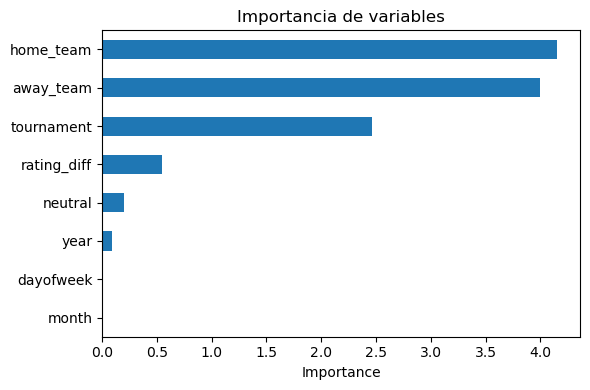

In [58]:
# Logistic Regression

clf = Pipeline(steps=[
    ("pre", pre),
    ("model", LogisticRegression(
        max_iter=1000,
        solver="lbfgs", 
        class_weight="balanced",
        C=1.0,
        random_state=42
    ))
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_logreg = clf.predict(X_te)
y_proba_logreg = clf.predict_proba(X_te)

# Importancia de features
try:
    feature_names = clf.named_steps["pre"].get_feature_names_out()
except Exception:
    feature_names = np.array(["home_team_TE","away_team_TE","tournament_TE"] + feat_num)

importances = pd.Series(np.mean(np.abs(clf.named_steps["model"].coef_), axis=0), index=feature_names).sort_values(ascending=False)

print("\nTop 10 importancias:")
print(importances.head(10))

plt.figure(figsize=(6,4))
importances.head(10).sort_values().plot(kind="barh")
plt.title("Importancia de variables")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [59]:
# KNN

clf = Pipeline(steps=[
    ("pre", pre),
    ("model", KNeighborsClassifier(
        n_neighbors=21, weights="distance", metric="minkowski", p=2
    ))
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_knn = clf.predict(X_te)
y_proba_knn = clf.predict_proba(X_te)

In [60]:
# SVM

clf = Pipeline(steps=[
    ("pre", pre),
    ("model", SVC(
        C=5,
        kernel="rbf",
        decision_function_shape='ovr',
        probability=True,
        class_weight="balanced",
        random_state=42
    ))
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_svm = clf.predict(X_te)
y_proba_svm = clf.predict_proba(X_te)

In [61]:
# Arbol de decisión

clf = Pipeline(steps=[
    ("pre", pre),
    ("model", DecisionTreeClassifier(
        criterion='entropy', 
        splitter='best', 
        max_depth=10,
        min_samples_split=8,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42)
    )
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_dtc = clf.predict(X_te)
y_proba_dtc = clf.predict_proba(X_te)

In [62]:
# Random Forest
clf = Pipeline(steps=[
    ("pre", pre),
    ("model", RandomForestClassifier(
        n_estimators=200,
        criterion='entropy',
        max_depth=15,
        min_samples_split=8,
        min_samples_leaf=3,
        class_weight='balanced_subsample',
        random_state=42
        )
    )
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_rfc = clf.predict(X_te)
y_proba_rfc = clf.predict_proba(X_te)

##### 4) Evaluación de Resultados: Análisis cuantitativo y cualitativo del rendimiento de los modelos utilizando métricas apropiadas. Se deben interpretar los resultados en el contexto del problema original.

In [63]:
# Funcion para imprimir resultados de clasificación
def print_classification_results(y_test, y_pred, model_name):
    print(f"\nResultados para {model_name}:")

    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

    print("\nClassification Report:\n", 
          classification_report(y_test, y_pred, 
                              target_names=["nowin", "win"],
                              zero_division=0))
    plot_normalized_confusion(y_test, y_pred)
    
def plot_normalized_confusion(y_true, y_pred, labels=["nowin", "win"],
                              title="Matriz de confusión", figsize=(4.5, 4)):
    # Matriz de confusión normalizada
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=figsize)
    disp.plot(values_format=".2f", cmap=None, colorbar=False)
    plt.title(title)
    plt.show()

📝 En el contexto de este problema, queremos observar:

- Como mejoran las predicciones en relación al problema de clasificación multiclase, al evitar el ruido causado por el "draw". 

- La precision como métrica que nos indica el grado de acierto en la predicción de un ganador (como local).


Resultados para Regresión Logística:

Accuracy: 0.7052788350157206
F1-score (macro): 0.7052497779702385

Classification Report:
               precision    recall  f1-score   support

       nowin       0.71      0.70      0.70      3019
         win       0.70      0.71      0.71      3024

    accuracy                           0.71      6043
   macro avg       0.71      0.71      0.71      6043
weighted avg       0.71      0.71      0.71      6043



<Figure size 450x400 with 0 Axes>

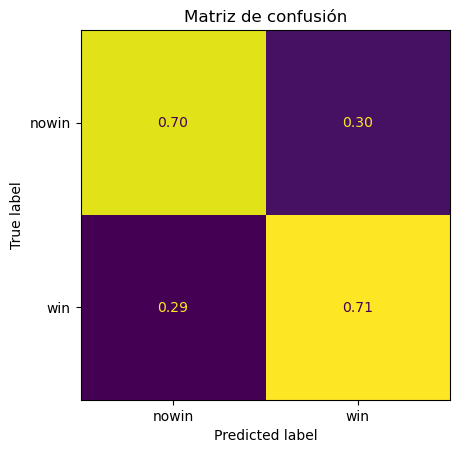


Resultados para KNN:

Accuracy: 0.674002978652987
F1-score (macro): 0.6739500415206869

Classification Report:
               precision    recall  f1-score   support

       nowin       0.68      0.66      0.67      3019
         win       0.67      0.69      0.68      3024

    accuracy                           0.67      6043
   macro avg       0.67      0.67      0.67      6043
weighted avg       0.67      0.67      0.67      6043



<Figure size 450x400 with 0 Axes>

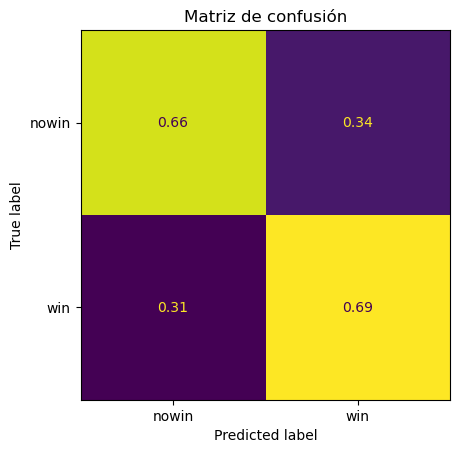


Resultados para SVC:

Accuracy: 0.7059407579017044
F1-score (macro): 0.7059381488750949

Classification Report:
               precision    recall  f1-score   support

       nowin       0.71      0.70      0.71      3019
         win       0.71      0.71      0.71      3024

    accuracy                           0.71      6043
   macro avg       0.71      0.71      0.71      6043
weighted avg       0.71      0.71      0.71      6043



<Figure size 450x400 with 0 Axes>

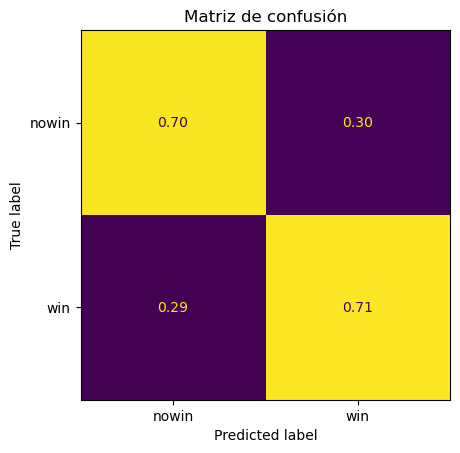


Resultados para Árbol de Decisión:

Accuracy: 0.6887307628661261
F1-score (macro): 0.6886079723589954

Classification Report:
               precision    recall  f1-score   support

       nowin       0.70      0.67      0.68      3019
         win       0.68      0.71      0.69      3024

    accuracy                           0.69      6043
   macro avg       0.69      0.69      0.69      6043
weighted avg       0.69      0.69      0.69      6043



<Figure size 450x400 with 0 Axes>

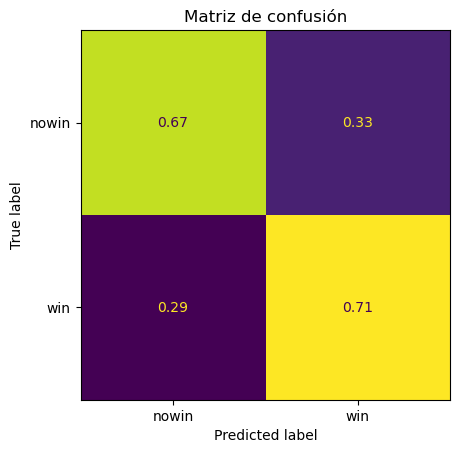


Resultados para Random Forest:

Accuracy: 0.7066026807876883
F1-score (macro): 0.7065980529268985

Classification Report:
               precision    recall  f1-score   support

       nowin       0.71      0.70      0.71      3019
         win       0.71      0.71      0.71      3024

    accuracy                           0.71      6043
   macro avg       0.71      0.71      0.71      6043
weighted avg       0.71      0.71      0.71      6043



<Figure size 450x400 with 0 Axes>

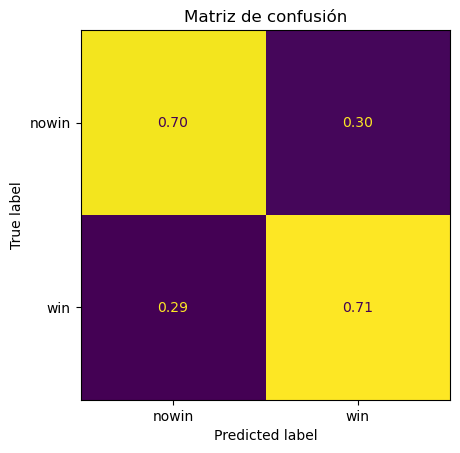

In [64]:
print_classification_results(y_te, y_pred_logreg, "Regresión Logística")
print_classification_results(y_te, y_pred_knn, "KNN")
print_classification_results(y_te, y_pred_svm, "SVC")
print_classification_results(y_te, y_pred_dtc, "Árbol de Decisión")
print_classification_results(y_te, y_pred_rfc, "Random Forest")

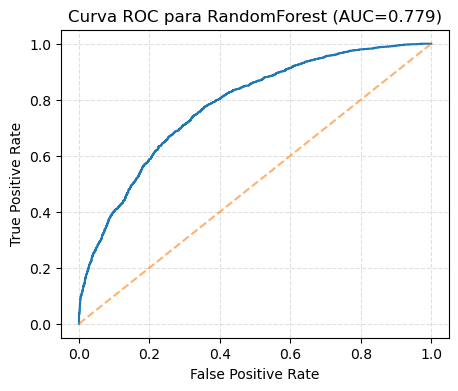

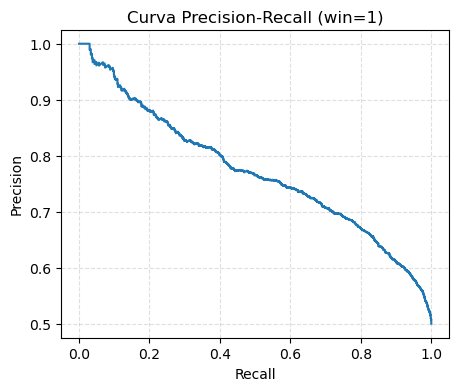

In [65]:
# clf es ahora Random Forest
p_win = clf.predict_proba(X_te)[:, 1]  # prob de win
y_pred05 = (p_win >= 0.5).astype(int)

acc = accuracy_score(y_te, y_pred05)
prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred05, average="binary", zero_division=0)
auc = roc_auc_score(y_te, p_win)

# Curvas ROC y PR
fpr, tpr, _ = roc_curve(y_te, p_win)
pr, rc, _ = precision_recall_curve(y_te, p_win)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Curva ROC para RandomForest (AUC={auc:.3f})")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

plt.figure(figsize=(5,4))
plt.plot(rc, pr)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall (win=1)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

Valores de AUC

Regresión logísica - 0.7759399902907687
KNN - 0.743869952382705
SVC - 0.7713859401918362
Desicion Tree Classifier - 0.742692116594899
Random Forest Classifier - 0.7785002742770215


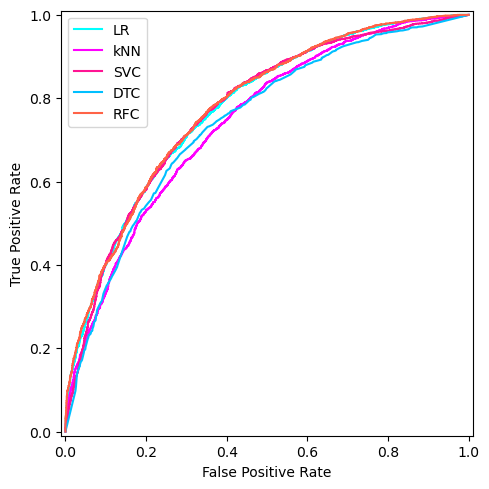

In [66]:
fpr_logreg, tpr_logreg, thr_logreg = roc_curve(y_te, y_proba_logreg[:, 1])
fpr_knn, tpr_knn, thr_knn = roc_curve(y_te, y_proba_knn[:, 1])
fpr_svc, tpr_svc, thr_svc = roc_curve(y_te, y_proba_svm[:, 1])
fpr_dtc, tpr_dtc, thr_dtc = roc_curve(y_te, y_proba_dtc[:, 1])
fpr_rfc, tpr_rfc, thr_rfc = roc_curve(y_te, y_proba_rfc[:, 1])

colors = ["#00FFFF", "#FF00FF", "#FF1493", "#00BFFF", "#FF6347"]

plt.figure(figsize=(5, 5))
plt.plot(fpr_logreg, tpr_logreg, label="LR", color=colors[0])
plt.plot(fpr_knn, tpr_knn, label="kNN", color=colors[1])
plt.plot(fpr_svc, tpr_svc, label="SVC", color=colors[2])
plt.plot(fpr_dtc, tpr_dtc, label="DTC", color=colors[3])
plt.plot(fpr_rfc, tpr_rfc, label="RFC", color=colors[4])
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()


print("Valores de AUC\n")
print("Regresión logísica -", roc_auc_score(y_te, y_proba_logreg[:, 1]))
print("KNN -", roc_auc_score(y_te, y_proba_knn[:, 1]))
print("SVC -", roc_auc_score(y_te, y_proba_svm[:, 1]))
print("Desicion Tree Classifier -", roc_auc_score(y_te, y_proba_dtc[:, 1]))
print("Random Forest Classifier -", roc_auc_score(y_te, y_proba_rfc[:, 1]))


BIN listo: 6,043 filas
tri_df cols: ['match_id', 'p_triclase']
Intersección para comparar: 3,140 partidos


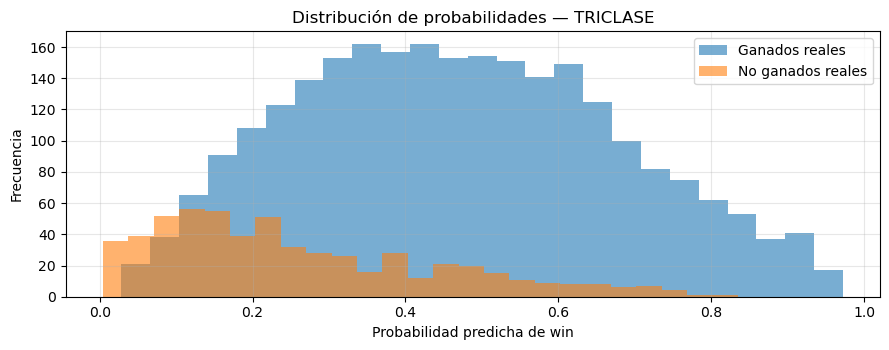

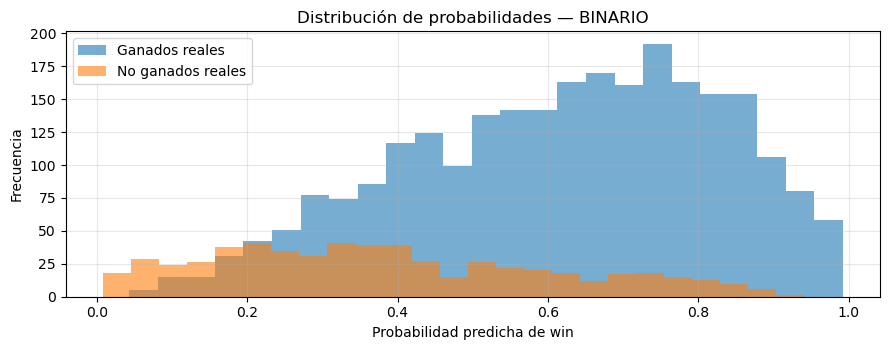

In [67]:
# COMPARACIÓN BINARIO vs TRICLASE (cargando .parquet del triclase)
# ============================================================

# Probabilidad BINARIA actual + claves ----------
# Binario: prob de win = columna 1 del predict_proba
p_binario = y_proba_logreg[:, 1]

# Claves desde el DF original alineadas con el test
keys_bin = df.loc[X_te.index, ["date","home_team","away_team"]].copy()
keys_bin["date_str"] = pd.to_datetime(keys_bin["date"]).dt.strftime("%Y-%m-%d")
keys_bin["match_id"] = keys_bin["date_str"] + "|" + keys_bin["home_team"] + "|" + keys_bin["away_team"]

bin_df = pd.DataFrame({
    "match_id": keys_bin["match_id"].values,
    "y_true_bin": y_te.values.astype(int),  # 0/1
    "p_binario": p_binario
})
print(f"BIN listo: {len(bin_df):,} filas")

# Cargar predicciones del TRICLASE ----------
def load_tri_preds(base_name="triclase_logreg_preds"):
    # intenta Parquet (fastparquet → pyarrow) y cae a CSV si no
    if os.path.exists(f"{base_name}.parquet"):
        try:
            return pd.read_parquet(f"{base_name}.parquet", engine="fastparquet")
        except Exception:
            return pd.read_parquet(f"{base_name}.parquet")
    elif os.path.exists(f"{base_name}.csv"):
        return pd.read_csv(f"{base_name}.csv")
    else:
        raise FileNotFoundError(f"No encontré {base_name}.parquet ni {base_name}.csv")

tri_df = load_tri_preds("triclase_logreg_preds").copy()

if "p_pred" in tri_df.columns:
    tri_df = tri_df.rename(columns={"p_pred": "p_triclase"})
tri_df = tri_df[["match_id", "p_triclase"]].copy()

# Normalizar columnas del TRICLASE ---
rename_map = {}
if "p_pred" in tri_df.columns:
    rename_map["p_pred"] = "p_triclase"

tri_df = tri_df.rename(columns=rename_map)

# Prob(win) del triclase y el ID
if "p_triclase" not in tri_df.columns:
    raise KeyError("No encuentro 'p_triclase' en tri_df (¿venía como 'p_pred'?).")

tri_df = tri_df[["match_id", "p_triclase"]].copy()
print("tri_df cols:", tri_df.columns.tolist())

# Merge e índices alineados
cmp = bin_df.merge(tri_df, on="match_id", how="inner")
print(f"Intersección para comparar: {len(cmp):,} partidos")

# Etiqueta SIEMPRE del binario (mismo split de este notebook)
y     = cmp["y_true_bin"].astype(int).values
p_bin = cmp["p_binario"].values
p_tri = cmp["p_triclase"].values

# Histogramas de como separa cada modelo las probs
plt.figure(figsize=(9,3.6))
plt.hist(p_tri[y==1], bins=25, alpha=0.6, label="Ganados reales")
plt.hist(p_tri[y==0], bins=25, alpha=0.6, label="No ganados reales")
plt.title("Distribución de probabilidades — TRICLASE")
plt.xlabel("Probabilidad predicha de win"); plt.ylabel("Frecuencia")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,3.6))
plt.hist(p_bin[y==1], bins=25, alpha=0.6, label="Ganados reales")
plt.hist(p_bin[y==0], bins=25, alpha=0.6, label="No ganados reales")
plt.title("Distribución de probabilidades — BINARIO")
plt.xlabel("Probabilidad predicha de win"); plt.ylabel("Frecuencia")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

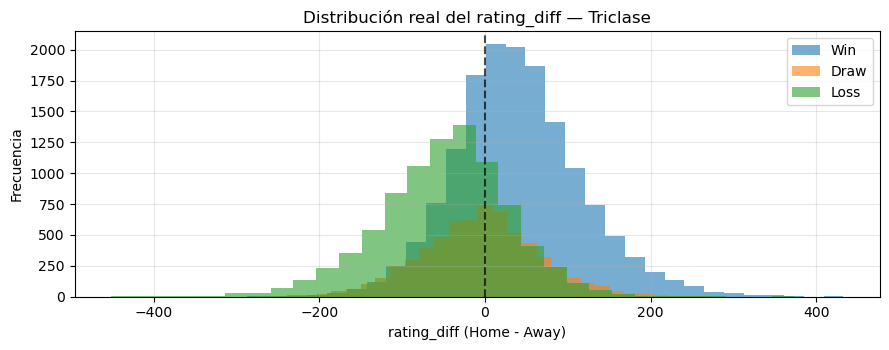

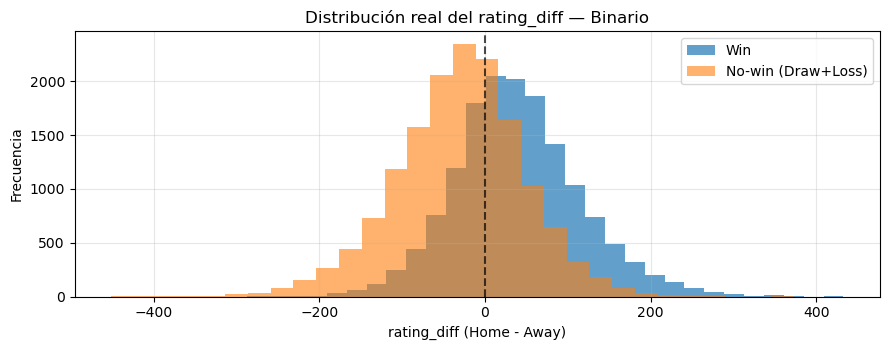

In [68]:
# Distribución real de rating_diff (TRICLASE y BINARIO) 
# ===============================================================

df_plot = df.copy()

# Aseguramos TRICLASE ('win','draw','loss') 
if "target" in df_plot.columns and df_plot["target"].dtype == "O":
    target_tri = df_plot["target"].astype(str)
else:
    # reconstruimos desde los goles
    if {"home_score","away_score"}.issubset(df_plot.columns):
        gd = df_plot["home_score"] - df_plot["away_score"]
        target_tri = np.select([gd>0, gd==0, gd<0], ["win","draw","loss"], default="draw")
    else:
        raise KeyError("No encuentro target triclase ni columnas de goles para reconstruirlo.")

df_plot["target_tri"] = target_tri

# Aseguramos BINARIO ('win' vs 'no-win') coherente
if "target" in df_plot.columns and df_plot["target"].dtype != "O":
    df_plot["target_bin_txt"] = df_plot["target"].map({1:"win", 0:"no-win"}).astype(str)
else:
    # derivamos del triclase
    df_plot["target_bin_txt"] = np.where(df_plot["target_tri"]=="win", "win", "no-win")

# TRICLASE: hist real
tri = df_plot[df_plot["target_tri"].isin(["win","draw","loss"])].copy()
if tri.empty:
    print("⚠️ No hay registros triclase (¿el DF actual ya está binarizado sin goles?).")
else:
    plt.figure(figsize=(9,3.6))
    plt.hist(tri.loc[tri["target_tri"]=="win",  "rating_diff"], bins=30, alpha=0.6, label="Win")
    plt.hist(tri.loc[tri["target_tri"]=="draw", "rating_diff"], bins=30, alpha=0.6, label="Draw")
    plt.hist(tri.loc[tri["target_tri"]=="loss", "rating_diff"], bins=30, alpha=0.6, label="Loss")
    plt.axvline(0, color="k", linestyle="--", alpha=0.7)
    plt.title("Distribución real del rating_diff — Triclase")
    plt.xlabel("rating_diff (Home - Away)")
    plt.ylabel("Frecuencia")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# BINARIO: hist real
plt.figure(figsize=(9,3.6))
plt.hist(df_plot.loc[df_plot["target_bin_txt"]=="win",    "rating_diff"], bins=30, alpha=0.7, label="Win")
plt.hist(df_plot.loc[df_plot["target_bin_txt"]=="no-win", "rating_diff"], bins=30, alpha=0.6, label="No-win (Draw+Loss)")
plt.axvline(0, color="k", linestyle="--", alpha=0.7)
plt.title("Distribución real del rating_diff — Binario")
plt.xlabel("rating_diff (Home - Away)")
plt.ylabel("Frecuencia")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

---

📝 Podemos concluir:

- El modelo binario es más eficiente porque reduce la complejidad de la frontera de decisión, como lo muestran los dos últimos histogramas.
- Al eliminar la clase ruidosa ("draw"). se alinea mejor la señal principal, rating_diff, con la pregunta clara de si el equipo gana o no gana.
- Hay consistencia en las predicciones de los modelos. El Accuracy promedio es de 0.70 y el F1 macro de 0.70, y la presicion promedio es de 0.69. Indican buenas predicciones de equipo ganador (como local).
- Al mirar la gráfica de comparación de las ROC, y los valores de AUC, vemos que el modelo Random Forest tiene un desempeño levemente mejor. 